 # Hackathon CNN
 ----
  
  University : UTEC \\
  Course       : Master in Data Science. \\
  Professor    : Cristian López Del Alamo \\
  Topic        : CNN \\
  
   

 ----

Write the names and surnames of the members and the percentage of participation of each one in the development of the practice:
 - Integrante 1:
 - Integrante 2:
 - Integrante 3:
 - Integrante 4:


 ----

### Título del Proyecto  
**Clasificación de Radiografías de Tórax para la Detección de COVID-19 Utilizando Redes Neuronales Convolucionales**

---

### Descripción del Proyecto  
En este proyecto, se propone el desarrollo de un modelo de red neuronal convolucional (CNN) para la clasificación automática de radiografías de tórax en pacientes con COVID-19 y sin COVID-19. Utilizando una base de datos de imágenes médicas, el objetivo principal es construir un sistema basado en inteligencia artificial que facilite el diagnóstico clínico, mejorando la precisión y reduciendo el tiempo de detección. Este enfoque aprovecha la capacidad de las redes neuronales convolucionales para extraer características relevantes de imágenes y distinguir patrones complejos asociados con enfermedades pulmonares.  



---

### Objetivos  

#### Objetivo General  
- Desarrollar un modelo de red neuronal convolucional capaz de clasificar radiografías de tórax y detectar la presencia de COVID-19 con alta precisión.

#### Objetivos Específicos  
1. **Preprocesar la base de datos de radiografías de tórax:** Normalizar y preparar las imágenes para asegurar su calidad y compatibilidad con el modelo CNN.  **(Este objetivo ya está resuelto para para usted)**
2. **Diseñar y entrenar una red neuronal convolucional:** Implementar una arquitectura CNN eficiente y optimizada para la clasificación de imágenes médicas.  
3. **Validar el modelo:** Evaluar el desempeño de la CNN mediante métricas relevantes como precisión, recall, F1-Score y acurracy.  
4. Reporte el mejor resultado.

Disfruten aprendiendo. 😊

### Database

Link para descagar la base de datos [Download here](https://drive.google.com/file/d/1-RGTR_EEW1Unm2JzMCP7u0lXfenmuQaB/view?usp=sharing)


1. Importamos las librerias y preparamos para usar cuda.





In [1]:
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import math, os, torchvision, torch
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from PIL import Image

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#print(device)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")


Using device: mps


2. Dados que los datos están en un archivo zip,  usamos librarias para desempaquetar los datos.

In [ ]:
#Install pyunpack to unzip the file covid.zip.
!pip install pyunpack
from google.colab import drive
from pyunpack import Archive

drive.mount('/content/drive/')
# No olvidar cambiar el path de la data para que funcione
zip_file = '/content/drive/MyDrive/UTEC/CURSOS/2023.1/INTELIGENCIA ARTIFICIA/DataSet/covid_dataset.zip'

Archive(zip_file).extractall('/content/')


# Show_img
Esta es una función que le ayudará  a ver las radiografías.

In [2]:

def Show_imgs(imgs, name,  size = 3, color = True):
  color_m ='jet'
  if color == False:
    color_m ='gray'
  print('******************' + name  +  '**************************')
  img_numbers = imgs.shape[0]
  rows = cols = math.ceil(np.sqrt(img_numbers))

  fig = plt.figure(figsize=(rows*size, cols*size))
  for i in range(0, rows*cols):
    fig.add_subplot(rows, cols,i+1)
    if i<img_numbers:
      plt.imshow(imgs[i].detach(), cmap = 'gray')
  plt.show()


# 3. Preprocesamiento

 En este paso realizamos un pre-procesamiento a las imágenes para que todas tenga el mismo tamaño, las convertimos a escala de gris, entre otras cosas.

 Esta taré ya está hecha para ustede. No debe añadir ni quitar nada.

In [3]:
import os
from shutil import copyfile

raw_folder = 'covid_dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
destiny_folder = 'preprocessed/'

def process_images(category, subfolder):
    _raw_folder = os.path.join(raw_folder, category)
    _destiny_folder = os.path.join(destiny_folder, subfolder)

    if not os.path.exists(_destiny_folder):
        os.makedirs(_destiny_folder)

    image_list = os.listdir(_raw_folder)

    for image in image_list:
        image_path = os.path.join(_raw_folder, image)
        destiny_path = os.path.join(_destiny_folder, image)
        # print(f'Processing {category} image: {image}')

        try:
            copyfile(image_path, destiny_path)

            im = Image.open(destiny_path)
            region = im.crop((100, 100, 1024, 1024))
            grayscale = region.convert('L')
            resized = grayscale.resize((256, 256), Image.LANCZOS)
            resized.save(destiny_path)
        except Exception as e:
            print(f"Error processing {category} image {image}: {e}")

process_images('Normal', 'normal')
process_images('COVID', 'covid')


# 4. Creamos el DataLoader

Este código le generará el train_loader y el test_loader listo para entrenar su modelo.

Usted no debe hacer nada aquí, ya está listo para que lo use.

In [27]:
import os
from PIL import Image
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def auto_crop_pil(img_pil):
    # Convertir a numpy, aplicar umbral y recortar
    import numpy as np
    import cv2

    img_np = np.array(img_pil)
    # asume escala de grises, si no, convértelo a 2D
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        gray = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
    else:
        gray = img_np

    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    coords = np.column_stack(np.where(thresh > 0))
    if len(coords) == 0:
        # Si no encuentra pixels > 0, retorna la imagen original
        return img_pil
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)
    cropped_np = img_np[x_min:x_max+1, y_min:y_max+1]

    return Image.fromarray(cropped_np)

def load_images(images_path, batch_size, seed=10):
    transform = transforms.Compose([
        transforms.Lambda(auto_crop_pil),
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])




    images_dataset = datasets.ImageFolder(images_path, transform=transform)

    for cls in images_dataset.classes:
        print(f'Class: {cls}')
        for img_path in images_dataset.imgs:
            if cls in img_path[0]:
                print(img_path[0])

    try:
        train_len = int(0.68 * len(images_dataset))
        test_len = len(images_dataset) - train_len

        train_dataset, test_dataset = random_split(images_dataset, [train_len, test_len], generator=torch.Generator().manual_seed(seed))
        train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
        test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

        return train_loader, test_loader
    except ValueError as e:
        print(f"ValueError: {e}")
        return None, None

In [28]:
# Ejecutamos nuestra función load_images para obtener los loaders.
# No necesita hacer nada aquí.

train_loader, test_loader = load_images('preprocessed', batch_size=64)


Class: covid
preprocessed/covid/COVID-1.png
preprocessed/covid/COVID-10.png
preprocessed/covid/COVID-100.png
preprocessed/covid/COVID-1000.png
preprocessed/covid/COVID-1001.png
preprocessed/covid/COVID-1002.png
preprocessed/covid/COVID-1003.png
preprocessed/covid/COVID-1004.png
preprocessed/covid/COVID-1005.png
preprocessed/covid/COVID-1006.png
preprocessed/covid/COVID-1007.png
preprocessed/covid/COVID-1008.png
preprocessed/covid/COVID-1009.png
preprocessed/covid/COVID-101.png
preprocessed/covid/COVID-1010.png
preprocessed/covid/COVID-1011.png
preprocessed/covid/COVID-1012.png
preprocessed/covid/COVID-1013.png
preprocessed/covid/COVID-1014.png
preprocessed/covid/COVID-1015.png
preprocessed/covid/COVID-1016.png
preprocessed/covid/COVID-1017.png
preprocessed/covid/COVID-1018.png
preprocessed/covid/COVID-1019.png
preprocessed/covid/COVID-102.png
preprocessed/covid/COVID-1020.png
preprocessed/covid/COVID-1021.png
preprocessed/covid/COVID-1022.png
preprocessed/covid/COVID-1023.png
preproces

# Crea tu código de CNN  
Aquí, tu equipo implementará su red neuronal convolucional (CNN).

- Utiliza capas de convolución (convolución, ReLU, MaxPooling).  
- Utiliza al menos 2 capas ocultas al final de tu red. Ten en cuenta que el número de neuronas finales depende del número de clases que estás clasificando.  
- Analiza para qué se utiliza la normalización por lotes (Batch Normalization) y aplícala en tu red.  
  [enlace](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)  
- Analiza para qué se utiliza Dropout y aplícalo en algunas de tus capas.  
  [enlace](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)  
- Compara los resultados con aquellos obtenidos sin utilizar Batch Normalization y Dropout.  


In [41]:
# Hiperparámetros
num_classes = 10
learning_rate = 0.0001
num_epochs = 300
batch_size = 64


import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(512)

        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512*16*16, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # Bloque 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)  # Reduce 32->16
        
        # Bloque 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)  # Reduce 16->8
        
        # Bloque 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)  # Reduce 8->4
        
        # Bloque 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)  # Reduce 4->2
        
        # Aplanar
        x = x.view(x.size(0), -1)  # [batch, 512*2*2]
        
        
        # Capa completamente conectada 1
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        # Capa completamente conectada 2
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        # Capa de salida
        x = self.fc3(x)
        return x
# Ejemplo de instanciación del modelo:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (drop

# Train
This function is responsible for performing the training.

In [42]:

def train(model, train_loader, num_epochs):
    loss_vals = []

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    running_loss = 0.0
    total_step = len(train_loader)
    list_loss = []
    list_time = []
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = loss_fn(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            list_loss.append(loss.item())
            list_time.append(i)
            i += 1

            if (i + 1) % 5 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    print('Finished Training Trainset')
    return list_loss  # , loss_vals, list_time


In [43]:
model = CNN().to(device)
train_loader, test_loader = load_images('preprocessed/', batch_size)
list_loss = train(model, train_loader, num_epochs)

Class: covid
preprocessed/covid/COVID-1.png
preprocessed/covid/COVID-10.png
preprocessed/covid/COVID-100.png
preprocessed/covid/COVID-1000.png
preprocessed/covid/COVID-1001.png
preprocessed/covid/COVID-1002.png
preprocessed/covid/COVID-1003.png
preprocessed/covid/COVID-1004.png
preprocessed/covid/COVID-1005.png
preprocessed/covid/COVID-1006.png
preprocessed/covid/COVID-1007.png
preprocessed/covid/COVID-1008.png
preprocessed/covid/COVID-1009.png
preprocessed/covid/COVID-101.png
preprocessed/covid/COVID-1010.png
preprocessed/covid/COVID-1011.png
preprocessed/covid/COVID-1012.png
preprocessed/covid/COVID-1013.png
preprocessed/covid/COVID-1014.png
preprocessed/covid/COVID-1015.png
preprocessed/covid/COVID-1016.png
preprocessed/covid/COVID-1017.png
preprocessed/covid/COVID-1018.png
preprocessed/covid/COVID-1019.png
preprocessed/covid/COVID-102.png
preprocessed/covid/COVID-1020.png
preprocessed/covid/COVID-1021.png
preprocessed/covid/COVID-1022.png
preprocessed/covid/COVID-1023.png
preproces

# Plots
Plot the loss function of your model.

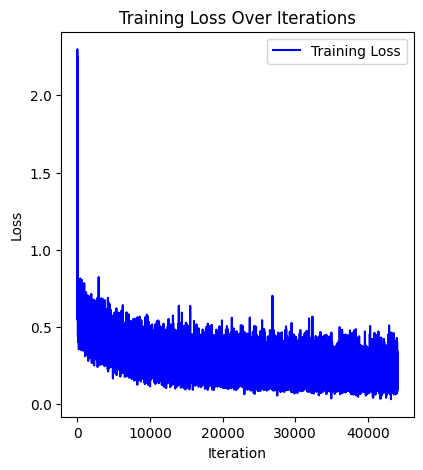

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the loss function
plt.figure(figsize=(10, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(list_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()




# Test
This code will allow you to test your model with the testing data.

In [45]:
def test(modelo,test_loader):
  modelo.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = modelo(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  test_accuracy = 100 * correct / total
  return test_accuracy, correct, total

test_accuracy, correct, total = test(model, test_loader)



# Plotting the test result
Plot the test result of your model.

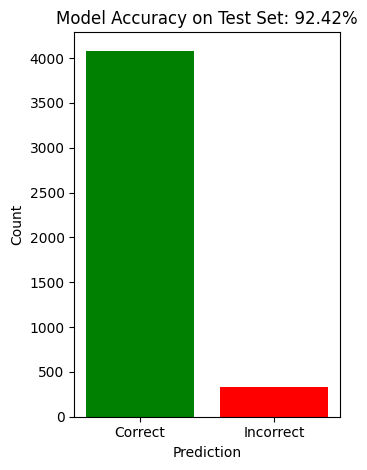

In [46]:

plt.subplot(1, 2, 2)
plt.bar(['Correct', 'Incorrect'], [correct, total - correct], color=['green', 'red'])
plt.title(f'Model Accuracy on Test Set: {test_accuracy:.2f}%')
plt.xlabel('Prediction')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

----

## Buena suerte y disfruten aprendiendo. 😊💪💪😊